<a href="https://colab.research.google.com/github/cengizmehmet/BenchmarkNets/blob/main/models/SPEC_Residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESIDUAL NETWORKS**

**Prepared by Mehmet CENGIZ**

ORCID: 0000-0003-4972-167X

This script is built to create Residual-inspired Networks trained in the SPEC CPU2017 dataset. The source of the dataset can be found on the website of Standard Performance Evaluation Corporation ([SPEC](https://www.spec.org/cpu2017/results/)). You can access the modified dataset in line with our requirements from the [data](https://github.com/cengizmehmet/BenchmarkNets/tree/main/data) folder of this repository. Those who will use this script is free to modify this adhering to their needs. As residual blocks are specified designs, for more information, please read its [paper](https://arxiv.org/abs/1512.03385).



---



## **NECESSARY DEPENDENCIES AND LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
from typing import Tuple, List
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Activation, Add, Flatten, Dense
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

**Versions:** This information is the library versions in Google Colab when the models were first designed (around the end of 2022). Version differences may occur due to time and programming environment changes.

* tensorflow: 2.12.0
* pandas: 1.5.3
* numpy: 1.22.4
* seaborn: 0.12.2
* sklearn-pandas: 2.2.0



## **NECESSARY FUNCTIONS**

**Method Name:** identity_block

**Parameters:** keras.Input, list

**Return:** keras.Input

This function builds the identity block which is an element of residual blocks as in the figure below.

This function accepts an keras tensor that hold the information of the previous block anda list that hold the details of the block to be created, and then, returns the final state of the tensor.


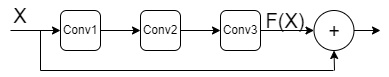

In [ ]:
def identity_block(X: keras.Input, filters_sizes: list) -> keras.Input:
  shortcut = X

  # First Layer
  X = Conv1D(filters = filters_sizes[0], kernel_size = 1, strides = 1, padding = 'valid')(X)
  X = Activation('relu')(X)

  # Second Layer
  X = Conv1D(filters = filters_sizes[1], kernel_size = 3, strides = 1, padding = 'same')(X)
  X = Activation('relu')(X)

  # Third Layer
  X = Conv1D(filters = filters_sizes[2], kernel_size = 1, strides = 1, padding = 'valid')(X)

  X = Add()([X, shortcut])
  X = Activation('relu')(X)
  
  return X

**Method Name:** convolutional_block

**Parameters:** keras.Input, list

**Return:** keras.Input

This function builds the convolutional block which is an element of residual blocks as in the figure below.

This function accepts an keras tensor that hold the information of the previous block anda list that hold the details of the block to be created. Distinctively, this function also allows for defining stride sizes, and then, returns the final state of the tensor.

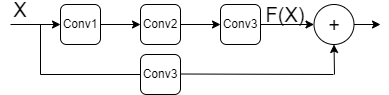

In [ ]:
def convolutional_block(X: keras.Input, filters_sizes: List, stride: int = 2) -> keras.Input:
  shortcut = X

  # First Layer
  X = Conv1D(filters = filters_sizes[0], kernel_size = 1, strides = stride, padding = 'same')(X)
  X = Activation('relu')(X)

  # Second Layer
  X = Conv1D(filters = filters_sizes[1], kernel_size = 3, strides = 1, padding = 'same')(X)
  X = Activation('relu')(X)

  # Third Layer
  X = Conv1D(filters = filters_sizes[2], kernel_size = 1, strides = 1, padding = 'valid')(X)

  # Reshaping the input tensor
  shortcut = Conv1D(filters = filters_sizes[2], kernel_size = 1, strides = stride, padding = 'valid')(shortcut)

  X = Add()([X, shortcut])
  X = Activation('relu')(X)
  
  return X

**Method Name:** residual_model

**Parameters:** tuple, list , tuple, int

**Return:** keras.Input

This function concatenates all identity and residual block as super block as in the image below, and then, returns the final state of the tensor.

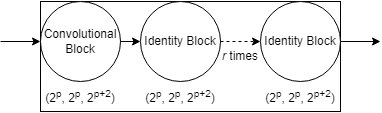

In [ ]:
def residual_model(input_shape: tuple, identity_block_nums: List, filters_sizes: tuple, stride: int = 2) -> keras.Input: 
  X_input = Input(input_shape)
  X = X_input

  first_ib_num = identity_block_nums[0]
  first_ib_filters = filters_sizes[0]

  X = Conv1D(filters = first_ib_filters[0], kernel_size = 3, activation = 'relu', strides = stride)(X)

  i = 0
  while i < len(identity_block_nums):
    filters = filters_sizes[i]
    X = convolutional_block(X, filters_sizes = filters, stride = stride)
    for c in range(identity_block_nums[i]):
      X = identity_block(X, filters_sizes = filters)
    i += 1

  X = Flatten()(X)
  X = Dense(1, activation = 'linear')(X)

  model = Model(inputs = X_input, outputs = X, name = 'ResidualModel')
  return model

**Method Name:** correlation

**Parameters:** str, float, bool, Tuple, isCbar, save

**Return:** set

This function calculates the correlation of each column and return the columns that have more than *abs(threshold)* correlation value.

* *corr_method* holds the correlation method. The correlation method may be kendall, spearman, and pearson. The default value is 'kendall'.
* *threshold* defines the acceptable correlation range. The default value is 0.7.
* *show* allows the matrix to be drawn or not. The default value is True
* *fig_dims* holds the size of the figure of the correlation matrix. The default value is (12, 8).
* *iscbar* allow the colour bar to be added or not. In some cases the figure of the correlation matrix does not fit the screen and the colour bar overlaps the matrix. The *isCbar* parameter exists to handle overlaps. The default values is True.
* *save* allows the save the figure of the matrix. The default values is False.

In [ ]:
def correlation(corr_method: str = 'kendall', threshold: float = 0.7, show: bool = True, fig_dims: Tuple = (12, 8),
                isCbar: bool = True, save: bool = False) -> set:
  corr_features = set()
  corr_matrix = dataset.corr(method = corr_method)
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]
        corr_features.add(colname)
  if show:
    fig, ax = plt.subplots(figsize = fig_dims)
    sns.heatmap(corr_matrix, ax = ax, annot = True, cmap = plt.cm.CMRmap_r, cbar = isCbar)
    if save:
        plt.savefig("png_format.png", dpi = 300, format = "png")
        plt.savefig("tiff_format.png", dpi = 300, format = "tiff")
    plt.show()
  return corr_features

**Method Name:** split_dataset

**Parameters:** pd.DataFrame, float, bool, str

**Return:** Tuple[list, list, list, list, list, list]

This function splits the dataset and returns each part.

* *dataset* is the dataset to be split.
* *target_column* holds the name of the target column.
* *split_ratio* defines the ratio of the training and test sets. The default value is 0.8 which means 80% of the dataset is split as the training dataset.
* *shuffle* allows the dataset to be shuffled. The default value is True.

This function returns:
* The training dataset
* The test dataset
* The independent columns of the training dataset
* The target column of the training dataset
* The independent columns of the test dataset
* The target column of the test dataset
* All independent columns as one list
* The target column as one list

In [ ]:
def split_dataset(dataset: pd.DataFrame, target_column: str, split_ratio: float = 0.8, shuffle: bool = True) -> Tuple[list, list, list, list, list, list]:  
  target_index = dataset.columns.get_loc(target_column)
  data = np.array(dataset)
  rows, columns = data.shape
  if shuffle:
    np.random.shuffle(data)
  train_size = int(split_ratio * rows)
  test_size = rows - train_size
  train = data[:train_size].T
  y_train = train[target_index]
  X_train = np.delete(train.T, obj = target_index, axis = 1)
  test = data[train_size:].T
  y_test = test[target_index]
  X_test = np.delete(test.T, obj = target_index, axis = 1)
  data = data.T
  y = data[target_index]
  X = np.delete(data.T, obj = target_index, axis = 1)
  return train.T, X_train, y_train, test.T, X_test, y_test, X, y

**Method Name:** factorize_columns

**Parameters:** pd.DataFrame, str

**Return:** pd.DataFrame, dictionary

This function converts values of the columns to type of the target column. The details of the factorization process is [here](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html).

* *dataset* is the dataset to be factorized.
* *target* holds the name of the target column.

This function return both the converted dataset and labels of each converted value.

In [ ]:
def factorize_columns(dataset: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, dict]:
  all_labels = {}
  for column in dataset.columns:
    if dataset[column].dtypes != dataset[target].dtypes:
      dataset[column], labels = pd.factorize(dataset[column])
      all_labels[column] = labels
  return dataset, all_labels

## **PREPROCESS**

The variables of the dataset:

In [ ]:
path = 'https://raw.githubusercontent.com/cengizmehmet/BenchmarkNets/main/data/SPEC2017_modified.csv'
dataset = pd.read_csv(path)
target = "Base_Result" #Target column

In [ ]:
attributes = dataset.columns
rows, columns = dataset.shape
dtypes = dataset.dtypes

print(attributes)
print("-----")
print("Columns: " + str(rows) + "\n" + "Rows: " + str(columns))
print("-----")
print(dtypes)

The variables related to the correlation analysis:

In [ ]:
corr_method = 'kendall'
threshold = 0.7 #It is accepted that higher and lower values than 0.7 and -0.7 respectively point out the high correlation
show = True #This defines whether the correlation matrix is drawn
fig_dims = (12, 8) #This defines the size of the figure in case draw is True
isCbar = False #This defines whether the colour bar is added as legend
save = False #This defines whether the correlation matrix is saved

In the following line, those two columns are dropped intentionally. The dataset contains two target column candidates: Peak Result and Base Result. Since we pick Base Result as the target column, Peak Result is dropped. The Disclosure column contains the HTML output of the benchmark of systems. Basically, it involves the same information as other columns.

In [ ]:
dataset = dataset.drop(['Peak_Result'], axis = 1)
dataset = dataset.drop(['Disclosures'], axis = 1)

In [ ]:
dataset, labels = factorize_columns(dataset, target)

In [ ]:
correlated_features = correlation(corr_method = corr_method, threshold = threshold, show = show,
                                  fig_dims = fig_dims, isCbar = isCbar, save = save)

In [ ]:
print(correlated_features)

In [ ]:
dataset = dataset.drop(correlated_features, axis = 1) #Correlated column are dropped

After dropping the correlated columns, their label also must be dropped.

In [ ]:
for label in correlated_features:
    labels.pop(label, None)

In order to provide controlled randomness, seeds are used.

In [ ]:
seed(1)

The variables related to the split dataset:

In [ ]:
m, n = dataset.shape
split = 0.8
shuffle = True

In [ ]:
train, X_train, y_train, test, X_test, y_test, X, y = split_dataset(dataset = dataset, target_column = target, split_ratio = split, shuffle = shuffle)

## **MODEL**

### **Initialisation**

The parameters of the MLP:

In [ ]:
input_shape = ((n - 1), 1)
identity_block_nums = [2, 5, 5, 2]
filter_sizes = ((64, 64, 256), (128, 128, 512), (256, 256, 1024), (512, 512, 2048))
stride_size = 1

In [ ]:
model = residual_model(input_shape, identity_block_nums, filter_sizes, stride_size)

In [ ]:
model.summary()

### **Training**

The training parameters:

In [ ]:
loss = "mean_absolute_error"
opt = "adam" 
learning_rate = 0.001
metrics = ["mean_absolute_error", "mean_squared_error", "mean_absolute_percentage_error", "mean_squared_logarithmic_error", "logcosh"]
epochs = 5
batch_size = 10
validation_split = 0.2
verbose = 1 #It may be 0 or 1

In [ ]:
model.compile(
        loss = loss,
        optimizer = opt,
        metrics = metrics
        )

In [ ]:
history = model.fit(
      X_train,
      y_train,
      epochs = epochs,
      batch_size = batch_size,
      verbose = verbose,
      validation_split = validation_split
      )

Performance of the training phase:

In [ ]:
#This line allow to store training results in a dictionary. 
results_dict = {}
for key in history.history.keys():
  results_dict[key] = history.history[key]

In [ ]:
#To present average performance of the model
for key in results_dict:
  print(str(key) + '= ' + str(sum(results_dict[key]) / len(results_dict[key])))

Plotting the results of the training phase:

In [ ]:
size = int(len(results_dict) / 2)
keys = list(results_dict.keys())
eps = range(1, epochs + 1)
for i in range(size):
  plt.plot(eps, results_dict[list(results_dict.keys())[i]], 'b', label = list(results_dict.keys())[i])
  plt.plot(eps, results_dict[list(results_dict.keys())[i + 6]], 'r', label = list(results_dict.keys())[i + 6])
  plt.xlabel('Epochs')
  plt.ylabel(list(results_dict.keys())[i])
  plt.legend()
  plt.show()

### **Test**

In [ ]:
preds = model.predict(X_test)

Evalution of the test:

In [ ]:
#Metrics
  #R2
r2_value = r2_score(y_test, preds)
print("R2 = " + str(r2_value))

  #MSE
mse = mean_squared_error(y_test, preds, squared = True)
print("MSE = " + str(mse))

  #RMSE
rmse = mean_squared_error(y_test, preds, squared = False)
print("RMSE = " + str(rmse))

  #MAE
mae = mean_absolute_error(y_test, preds)
print("MAE = " + str(mae))

  #Explained Variance Score
evs = explained_variance_score(y_test, preds)
print("EVS = " + str(evs))

  #Mean Pinball Loss
mpl = mean_pinball_loss(y_test, preds)
print("MPL = " + str(mpl))

Plotting the results of the test phase:

In [ ]:
#Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, preds, c='crimson')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')
plt.show()

In [ ]:
#Heat map
xy = np.vstack([y_test, preds.flatten()])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = y_test[idx], preds[idx], z[idx]
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')
cax = ax.scatter(x, y, c=z, s=50)
fig.colorbar(cax)
plt.show()